In [90]:
%reset -f
from parflow import Run
from parflow.tools.fs import get_absolute_path
from parflow.tools.io import write_pfb, read_pfb
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
from utils import init_location, cal_z_locid, cal_velz_loc, \
                  interpolate_vel, data_normalize, To_Tensor
# from parflow.tools.hydrology import calculate_water_table_depth, \
# calculate_overland_flow_grid, calculate_overland_fluxes
# %matplotlib widget

In [78]:
p_start = 35040
t_start = 0 #iteration start
t_end = 10 #iteration end
real_path = 'False'
selectd = np.array([0,20,0,5,0,20])

npcell = 40  #used for train
testsize = 4  #used for test
npcell = npcell + testsize  #all
# how many particles in a grid cell

interval = 1 #always no gap
step_size = 1 #always one hour

In [79]:
# input model parameters
nx = 20
ny = 5
nz = 20

dx = 5
dy = 0.2
dz = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, \
               0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.3, 0.1])

boundings = np.array([0., 100., 0., 1., 0., 9.4])

In [ ]:
for ii in range(t_start,t_end):
    
    istep = 1 + ii #current iterate step
    print('istep',istep)

    Vx = read_pfb(get_absolute_path('./vel_field/hillslope_clm_ER_shrub.out.velx.' \
                                    +str(istep+p_start).zfill(5)+'.pfb'))
    Vy = read_pfb(get_absolute_path('./vel_field/hillslope_clm_ER_shrub.out.vely.' \
                                    +str(istep+p_start).zfill(5)+'.pfb'))
    Vz = read_pfb(get_absolute_path('./vel_field/hillslope_clm_ER_shrub.out.velz.' \
                                    +str(istep+p_start).zfill(5)+'.pfb'))
    Saturation = read_pfb(get_absolute_path('./vel_field/hillslope_clm_ER_shrub.out.satur.' \
                                            +str(istep+p_start).zfill(5)+'.pfb'))
    Porosity = read_pfb(get_absolute_path('./vel_field/hillslope_clm_ER_shrub.out.porosity.pfb'))
    # print(Vx.shape, Vy.shape, Vz.shape)

    if real_path == 'False' or (real_path == 'True' and istep == (t_start + 1)):
        
        #setup initial location
        initx,inity,initz = init_location(npcell,nx,ny,nz,dx,dy,dz)
        # initz[1,0,:,:]

        #cal locid
        Px = np.copy(initx)
        Py = np.copy(inity)
        Pz = np.copy(initz)
        
        print('real_path',real_path)
    
    if real_path == 'True' and istep != (t_start + 1):
        
        initx = np.copy(Px)
        inity = np.copy(Py)
        initz = np.copy(Pz)
        
        print('real_path',real_path)

    Plocx = np.floor(Px/dx)
    Plocy = np.floor(Py/dy)
    Plocz = cal_z_locid(npcell,nx,ny,nz,dz,Pz)

    # cal vel loc
    # this can be got by random number directly
    # but for multiple steps, we still need to calculate
    # so we provide the template here
    # we may also calculate it from random number
    # i mean like add the intial fraction with the new_distance/vel
    # but additional other calculation may need

    Clocx = (Px - Plocx*dx)/dx
    Clocy = (Py - Plocy*dy)/dy
    Clocz = cal_velz_loc(npcell,nx,ny,nz,dz,Pz,Plocz)

    Vpx, Vpy, Vpz = interpolate_vel(npcell,nx,ny,nz,Plocx,Plocy,Plocz,Clocx,Clocy,Clocz, \
                                   Vx,Vy,Vz,Saturation,Porosity)

    Px[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]] = \
    Px[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]] + \
    Vpx[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]]
    
    Py[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]] = \
    Py[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]] + \
    Vpy[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]]
    
    Pz[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]] = \
    Pz[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]] + \
    Vpz[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]]

    tt,initx1,inity1,initz1,Px1,Py1,Pz1 = data_normalize(istep,interval,step_size,t_start,t_end, \
                                                   initx,inity,initz,Px,Py,Pz,boundings)

    start_train_new, end_train_new, time_train_new = To_Tensor(0,npcell-testsize, \
               selectd[0],selectd[2],selectd[4],selectd[1],selectd[3],selectd[5], \
                                                initx1,inity1,initz1,Px1,Py1,Pz1,tt)
    start_test_new, end_test_new, time_test_new = To_Tensor(npcell-testsize,npcell, \
               selectd[0],selectd[2],selectd[4],selectd[1],selectd[3],selectd[5], \
                                                initx1,inity1,initz1,Px1,Py1,Pz1,tt)
    
    if istep == t_start + 1:
        start_train = start_train_new
        end_train   = end_train_new
        time_train  = time_train_new
        
        start_test  = start_test_new
        end_test    = end_test_new
        time_test   = time_test_new
        
    else:
        
        start_train = torch.cat((start_train, start_train_new),dim=0)
        end_train   = torch.cat((end_train, end_train_new),dim=0)
        time_train  = torch.cat((time_train, time_train_new),dim=0)
        
        start_test  = torch.cat((start_test, start_test_new),dim=0)
        end_test    = torch.cat((end_test, end_test_new),dim=0)
        time_test   = torch.cat((time_test, time_test_new),dim=0)
    

In [81]:
print(start_train.shape,start_test.shape,end_train.shape,end_test.shape)

torch.Size([799778, 3]) torch.Size([79974, 3]) torch.Size([799778, 3]) torch.Size([79974, 3])


In [82]:
data_train = TensorDataset(start_train,end_train,time_train)
data_test = TensorDataset(start_test,end_test,time_test)

if real_path == 'True':
    torch.save(data_train,'data_check.pth')  
else:
    torch.save(data_train,'data_train.pth')
    torch.save(data_test,'data_test.pth')

In [ ]:
count = 0
for x in data_train:#generator
    print(x)
    count = count + 1
    if count > 1000: break

In [91]:
data_train = torch.load('./data_check.pth')

b = data_train[:][0]
a = b.numpy()

b = data_train[:][1]
c = b.numpy()

b = data_train[:][2]
t = b.numpy()

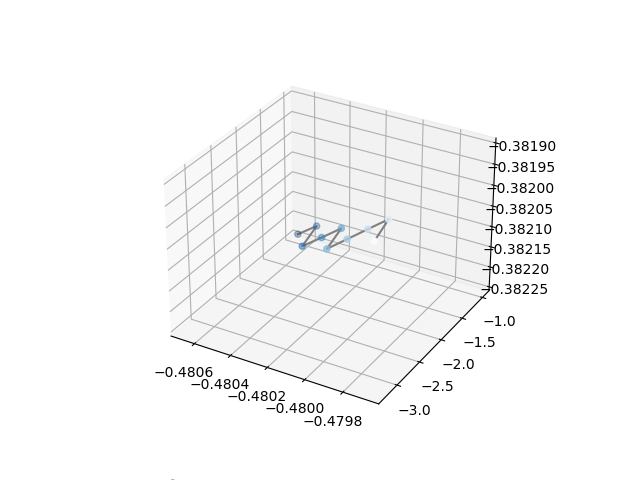

In [92]:
# import time
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
# for ii in range(600):
ii =10
xline = c[ii:6000:600,0]
yline = c[ii:6000:600,1]
zline = c[ii:6000:600,2]
xline0 = a[ii:6000:600,0]
yline0 = a[ii:6000:600,1]
zline0 = a[ii:6000:600,2]
tdata = t[ii:6000:600]
ax.plot3D(xline, yline, zline, 'gray')
# ax.plot3D(xline0, yline0, zline0, 'blue')
ax.scatter3D(xline, yline, zline, c = tdata, cmap='Blues')
# time.sleep(2)
# ax.show()